In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as ds_games_matchup

In [164]:
games_matchup = ds_games_matchup.load_game_matchup_dataset()

In [165]:
df = games_matchup[games_matchup.SEASON >= 2013]

In [222]:
games_matchup.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

In [167]:
tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_columns, model_config.y_columns[-1:])
for train_index, test_index in tscv.split(X=X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   0    1    2 ... 1227 1228 1229] TEST: [1230 1231 1232 ... 2457 2458 2459]
TRAIN: [1230 1231 1232 ... 2457 2458 2459] TEST: [2460 2461 2462 ... 3687 3688 3689]
TRAIN: [2460 2461 2462 ... 3687 3688 3689] TEST: [3690 3691 3692 ... 4917 4918 4919]
TRAIN: [3690 3691 3692 ... 4917 4918 4919] TEST: [4920 4921 4922 ... 6147 6148 6149]
TRAIN: [4920 4921 4922 ... 6147 6148 6149] TEST: [6150 6151 6152 ... 7377 7378 7379]


In [168]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

In [169]:
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))) 
models.append(('SVM', SVC(kernel = 'linear', random_state=0))) 
models.append(('KSVM', SVC(kernel = 'rbf', random_state=0))) 
models.append(('NB', GaussianNB())) 
models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=0))) 
models.append(("RF", RandomForestClassifier(n_estimators=500, 
                                            max_features="sqrt", 
                                            max_depth=15, 
                                            n_jobs=-1, 
                                            random_state = 0)))
models.append(("GB", GradientBoostingClassifier(n_estimators=500, 
                                                max_depth=15, 
                                                max_features="sqrt", 
                                                random_state = 0)))

train_splits = len(df.SEASON.unique())-1
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=train_splits, max_train_size=1230)
    X, y = train.X_y_values(df, model_config.X_columns, model_config.y_columns[-1:])

    cv_results = cross_validate(model,
                                 X,
                                 y.ravel(),
                                 cv=tscv,
                                 scoring=['balanced_accuracy', 'precision', "recall"])
    
    cv_results["model"] = [name]*train_splits
    cv_results["season_train"] = df.SEASON.unique()[:-1]
    results.append(cv_results)
    
    names.append(name)
    
    print('%s %s: %f (%f)' % ('balanced_accuracy', name, cv_results["test_balanced_accuracy"].mean()
                              , cv_results["test_balanced_accuracy"].std()))
    print('%s %s: %f (%f)' % ("precision", name, cv_results["test_precision"].mean()
                               , cv_results["test_precision"].std()))
    print('%s %s: %f (%f)' % ("recall", name, cv_results["test_recall"].mean()
                               , cv_results["test_recall"].std()))
    print("\n")

balanced_accuracy KNN: 0.643143 (0.011045)
precision KNN: 0.698508 (0.015369)
recall KNN: 0.725884 (0.011611)


balanced_accuracy SVM: 0.691841 (0.018044)
precision SVM: 0.746681 (0.038404)
recall SVM: 0.744785 (0.066197)


balanced_accuracy KSVM: 0.500000 (0.000000)
precision KSVM: 0.583740 (0.006443)
recall KSVM: 1.000000 (0.000000)


balanced_accuracy NB: 0.668796 (0.018758)
precision NB: 0.738011 (0.019009)
recall NB: 0.672927 (0.028475)


balanced_accuracy DT: 0.608603 (0.011997)
precision DT: 0.682654 (0.023121)
recall DT: 0.630129 (0.037921)


balanced_accuracy RF: 0.675505 (0.023633)
precision RF: 0.720341 (0.033010)
recall RF: 0.778906 (0.036345)


balanced_accuracy GB: 0.680081 (0.022837)
precision GB: 0.750017 (0.031196)
recall GB: 0.680408 (0.024550)




In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
# Compare Algorithms\n",
from operator import itemgetter
tba_results = list(map(itemgetter('test_balanced_accuracy'), results)) 
ax1.boxplot(tba_results, labels=names)
ax1.set_title('test_balanced_accuracy')
tbp_results = list(map(itemgetter('test_precision'), results)) 
ax2.boxplot(tbp_results, labels=names)
ax2.set_title('test_precision')
tbc_results = list(map(itemgetter('test_recall'), results)) 
ax3.boxplot(tbc_results, labels=names)
ax3.set_title('test_recall')
#plt.show()

In [170]:
utils.save_results("tscv_1season", results)
results

[{'fit_time': array([0.00595188, 0.00334263, 0.00335455, 0.00342369, 0.00363827]),
  'score_time': array([0.10456395, 0.09705472, 0.10559678, 0.09853196, 0.11069012]),
  'test_balanced_accuracy': array([0.63679918, 0.65573887, 0.64588048, 0.62517353, 0.65212374]),
  'test_precision': array([0.68715847, 0.71181939, 0.70189702, 0.67522465, 0.71643836]),
  'test_recall': array([0.71145686, 0.74033149, 0.72144847, 0.73876404, 0.71742112]),
  'model': ['KNN', 'KNN', 'KNN', 'KNN', 'KNN'],
  'season_train': array([2013, 2014, 2015, 2016, 2017])},
 {'fit_time': array([0.50221682, 0.44862437, 0.72701931, 0.72671151, 1.04988885]),
  'score_time': array([0.03373575, 0.03573823, 0.03402758, 0.04026985, 0.03880644]),
  'test_balanced_accuracy': array([0.69298276, 0.71488819, 0.66776473, 0.67572719, 0.70784357]),
  'test_precision': array([0.72847682, 0.75793651, 0.71870794, 0.7115869 , 0.81669691]),
  'test_recall': array([0.77793494, 0.79143646, 0.74373259, 0.79353933, 0.61728395]),
  'model': ['S

In [171]:
results_df = pd.DataFrame(results[0])
for idx, result in enumerate(results[1:]):
    result_df = pd.DataFrame(result)
    results_df = pd.concat([results_df, result_df], ignore_index=True)

In [173]:
results_df

,fit_time,score_time,test_balanced_accuracy,test_precision,test_recall,model,season_train
0,0.005952,0.104564,0.636799,0.687158,0.711457,KNN,2013
1,0.003343,0.097055,0.655739,0.711819,0.740331,KNN,2014
2,0.003355,0.105597,0.645880,0.701897,0.721448,KNN,2015
3,0.003424,0.098532,0.625174,0.675225,0.738764,KNN,2016
4,0.003638,0.110690,0.652124,0.716438,0.717421,KNN,2017
5,0.502217,0.033736,0.692983,0.728477,0.777935,SVM,2013
6,0.448624,0.035738,0.714888,0.757937,0.791436,SVM,2014
7,0.727019,0.034028,0.667765,0.718708,0.743733,SVM,2015
8,0.726712,0.040270,0.675727,0.711587,0.793539,SVM,2016
9,1.049889,0.038806,0.707844,0.816697,0.617284,SVM,2017


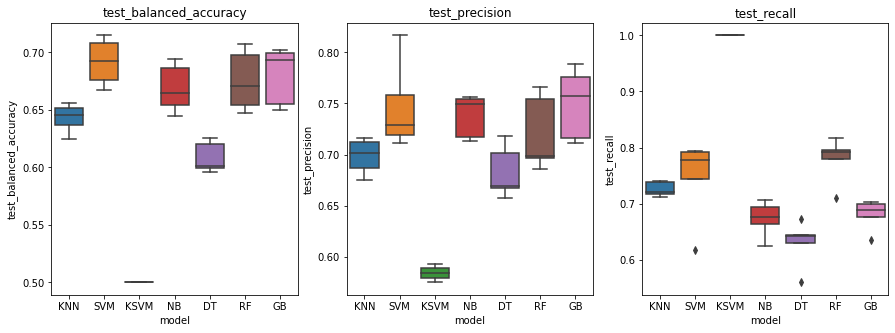

In [176]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax=sns.boxplot(x="model", y="test_balanced_accuracy", data=results_df, ax=ax1).set_title("test_balanced_accuracy")
ax= sns.boxplot(x="model", y="test_precision", data=results_df, ax=ax2).set_title("test_precision")
ax=sns.boxplot(x="model", y="test_recall", data=results_df, ax=ax3).set_title("test_recall")

In [177]:
#sns.lineplot(data=result_df, x="test_balanced_accuracy",y="model")
results_df.head()



,fit_time,score_time,test_balanced_accuracy,test_precision,test_recall,model,season_train
0,0.005952,0.104564,0.636799,0.687158,0.711457,KNN,2013
1,0.003343,0.097055,0.655739,0.711819,0.740331,KNN,2014
2,0.003355,0.105597,0.645880,0.701897,0.721448,KNN,2015
3,0.003424,0.098532,0.625174,0.675225,0.738764,KNN,2016
4,0.003638,0.110690,0.652124,0.716438,0.717421,KNN,2017


In [203]:
results_wide = results_df.pivot("season_train", "model", "test_balanced_accuracy")
results_wide

model,DT,GB,KNN,KSVM,NB,RF,SVM
season_train,,,,,,,
2013,0.599540,0.699478,0.636799,0.5,0.693951,0.670720,0.692983
2014,0.625873,0.702321,0.655739,0.5,0.686606,0.707685,0.714888
2015,0.596421,0.655246,0.645880,0.5,0.644673,0.654052,0.667765
2016,0.601023,0.649557,0.625174,0.5,0.654383,0.647472,0.675727
2017,0.620155,0.693806,0.652124,0.5,0.664367,0.697597,0.707844


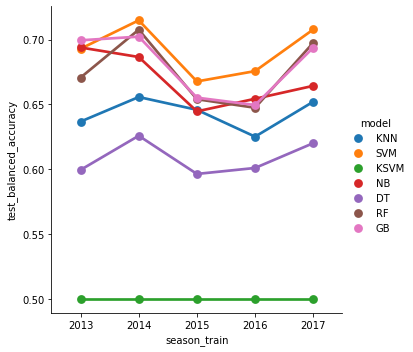

In [217]:
ax = sns.catplot(data=results_df,
            kind="point", x="season_train", y="test_balanced_accuracy", hue="model")

In [12]:
#splits = np.arange(0, len(results[0]), 1)
from sklearn.metrics import SCORERS
sorted(SCORERS.keys()) 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [ ]:
plt.plot(splits, results[0])
plt.show()

In [ ]:
plt.plot(splits, results[1])
plt.show()